<a href="https://colab.research.google.com/github/LGCilento/Intrusion-Detection-System-Using-CNN-and-Transfer-Learning/blob/main/CAN_IDS_notebooks_MERGE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CHAPTER 1: A Transfer Learning and Optimized CNN Based Intrusion Detection System for Internet of Vehicles 
This is the code for the paper entitled "**A Transfer Learning and Optimized CNN Based Intrusion Detection System for Internet of Vehicles**" accepted in IEEE International Conference on Communications (IEEE ICC).  
Authors: Li Yang (lyang339@uwo.ca) and Abdallah Shami (Abdallah.Shami@uwo.ca)  
Organization: The Optimized Computing and Communications (OC2) Lab, ECE Department, Western University

**Notebook 1: Data pre-processing**  
Procedures:  
&nbsp; 1): Read the dataset  
&nbsp; 2): Transform the tabular data into images  
&nbsp; 3): Display the transformed images  
&nbsp; 4): Split the training and test set  

## Import libraries

In [1]:
!nvidia-smi

Sat Apr 23 20:46:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import math
import random
import matplotlib.pyplot as plt
import shutil
from sklearn.preprocessing import QuantileTransformer
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

In [3]:

import tensorflow as tf 
import keras

print(keras.__version__)
print(tf.__version__)
print(np.__version__)
print(pd.__version__)
print(cv2.__version__)
#print(sklearn.__version__)

2.8.0
2.8.0
1.21.6
1.3.5
4.1.2


## Read the Car-Hacking/CAN-Intrusion dataset
The complete Car-Hacking dataset is publicly available at: https://ocslab.hksecurity.net/Datasets/CAN-intrusion-dataset  
In this repository, due to the file size limit of GitHub, we use the 5% subset.

In [4]:
#UNNCOMENT THIS CELL FOR COLAB EXECUTION WITH DRIVE

# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
##EXCLUSIVE FOR COLAB
#from google.colab import drive
#drive.mount('/content')
link = 'https://drive.google.com/open?id=1lBnmDvriKQoAyqpinwHWWYqFLhMrE2hH'
#https://drive.google.com/file/d/1lBnmDvriKQoAyqpinwHWWYqFLhMrE2hH/view?usp=sharing
fluff, id = link.split('=')


downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Car_Hacking_5%.csv')  
df = pd.read_csv('Car_Hacking_5%.csv')

In [6]:
%%time
#Read dataset
#df=pd.read_csv('data/Car_Hacking_5%.csv')

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs


In [7]:
%%time
df

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.44 µs


,CAN ID,DATA[0],DATA[1],DATA[2],DATA[3],DATA[4],DATA[5],DATA[6],DATA[7],Label
0,1201,41,39,39,35,0,0,0,154,R
1,809,64,187,127,20,17,32,0,20,R
2,1349,216,0,0,136,0,0,0,0,R
3,1201,41,39,39,35,0,0,0,154,R
4,2,0,0,0,0,0,3,2,228,R
...,...,...,...,...,...,...,...,...,...,...
818435,848,5,32,52,104,117,0,0,12,R
818436,1088,255,0,0,0,255,134,9,0,R
818437,848,5,32,100,104,117,0,0,92,R
818438,1349,216,90,0,137,0,0,0,0,R


In [8]:
%%time
# The labels of the dataset. "R" indicates normal patterns, and there are four types of attack (DoS, fuzzy. gear spoofing, and RPM spoofing zttacks)
df.Label.value_counts()

CPU times: user 35.4 ms, sys: 1.24 ms, total: 36.6 ms
Wall time: 40.9 ms


R        701832
RPM       32539
gear      29944
DoS       29501
Fuzzy     24624
Name: Label, dtype: int64

## Data Transformation
Convert tabular data to images
Procedures:
1. Use quantile transform to transform the original data samples into the scale of [0,255], representing pixel values
2. Generate images for each category (Normal, DoS, Fuzzy, Gear, RPM), each image consists of 27 data samples with 9 features. Thus, the size of each image is 9*9*3, length 9, width 9, and 3 color channels (RGB).

In [9]:
%%time
# Transform all features into the scale of [0,1]
numeric_features = df.dtypes[df.dtypes != 'object'].index
scaler = QuantileTransformer() 
df[numeric_features] = scaler.fit_transform(df[numeric_features])

CPU times: user 1.13 s, sys: 30.3 ms, total: 1.16 s
Wall time: 1.23 s


In [10]:
%%time
# Multiply the feature values by 255 to transform them into the scale of [0,255]
df[numeric_features] = df[numeric_features].apply(
    lambda x: (x*255))

CPU times: user 82.2 ms, sys: 30 ms, total: 112 ms
Wall time: 124 ms


In [11]:
%%time
df.describe()

CPU times: user 304 ms, sys: 7.89 ms, total: 312 ms
Wall time: 327 ms


,CAN ID,DATA[0],DATA[1],DATA[2],DATA[3],DATA[4],DATA[5],DATA[6],DATA[7]
count,818440.000000,818440.000000,818440.000000,818440.000000,818440.000000,818440.000000,818440.000000,818440.000000,818440.000000
mean,127.517842,113.573040,107.995462,89.690088,109.715633,105.730262,112.153821,84.912810,93.028861
std,73.745540,89.904605,93.389381,100.740550,103.582260,95.775183,90.918495,101.324232,100.155234
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,66.621622,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,122.139640,126.096096,115.503003,0.000000,129.542042,127.627628,129.286787,0.000000,0.000000
75%,190.548048,192.207207,193.228228,199.737237,190.675676,193.483483,189.909910,191.824324,190.675676
max,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000


All features are in the same scale of [0,255]

### Generate images for each class

In [12]:
%%time
df0=df[df['Label']=='R'].drop(['Label'],axis=1)
df1=df[df['Label']=='RPM'].drop(['Label'],axis=1)
df2=df[df['Label']=='gear'].drop(['Label'],axis=1)
df3=df[df['Label']=='DoS'].drop(['Label'],axis=1)
df4=df[df['Label']=='Fuzzy'].drop(['Label'],axis=1)

CPU times: user 245 ms, sys: 830 µs, total: 246 ms
Wall time: 246 ms


In [13]:
%%time
# Generate 9*9 color images for class 0 (Normal)
count=0
ims = []

image_path = "train/0/"
os.makedirs(image_path)

for i in range(0, len(df0)):  
    count=count+1
    if count<=27: 
        im=df0.iloc[i].values
        ims=np.append(ims,im)
    else:
        ims=np.array(ims).reshape(9,9,3)
        array = np.array(ims, dtype=np.uint8)
        new_image = Image.fromarray(array)
        new_image.save(image_path+str(i)+'.png')
        count=0
        ims = []

CPU times: user 58.4 s, sys: 1.79 s, total: 1min
Wall time: 1min 7s


In [14]:
%%time
# Generate 9*9 color images for class 1 (RPM spoofing)
count=0
ims = []

image_path = "train/1/"
os.makedirs(image_path)

for i in range(0, len(df1)):  
    count=count+1
    if count<=27: 
        im=df1.iloc[i].values
        ims=np.append(ims,im)
    else:
        ims=np.array(ims).reshape(9,9,3)
        array = np.array(ims, dtype=np.uint8)
        new_image = Image.fromarray(array)
        new_image.save(image_path+str(i)+'.png')
        count=0
        ims = []

CPU times: user 2.15 s, sys: 73.6 ms, total: 2.23 s
Wall time: 2.2 s


In [15]:
%%time
# Generate 9*9 color images for class 2 (Gear spoofing)
count=0
ims = []

image_path = "train/2/"
os.makedirs(image_path)

for i in range(0, len(df2)):  
    count=count+1
    if count<=27: 
        im=df2.iloc[i].values
        ims=np.append(ims,im)
    else:
        ims=np.array(ims).reshape(9,9,3)
        array = np.array(ims, dtype=np.uint8)
        new_image = Image.fromarray(array)
        new_image.save(image_path+str(i)+'.png')
        count=0
        ims = []

CPU times: user 2.03 s, sys: 80.6 ms, total: 2.12 s
Wall time: 2.1 s


In [16]:
%%time
# Generate 9*9 color images for class 3 (DoS attack)
count=0
ims = []

image_path = "train/3/"
os.makedirs(image_path)


for i in range(0, len(df3)):  
    count=count+1
    if count<=27: 
        im=df3.iloc[i].values
        ims=np.append(ims,im)
    else:
        ims=np.array(ims).reshape(9,9,3)
        array = np.array(ims, dtype=np.uint8)
        new_image = Image.fromarray(array)
        new_image.save(image_path+str(i)+'.png')
        count=0
        ims = []

CPU times: user 1.94 s, sys: 70.5 ms, total: 2.01 s
Wall time: 1.99 s


In [17]:
%%time
# Generate 9*9 color images for class 4 (Fuzzy attack)
count=0
ims = []

image_path = "train/4/"
os.makedirs(image_path)


for i in range(0, len(df4)):  
    count=count+1
    if count<=27: 
        im=df4.iloc[i].values
        ims=np.append(ims,im)
    else:
        ims=np.array(ims).reshape(9,9,3)
        array = np.array(ims, dtype=np.uint8)
        new_image = Image.fromarray(array)
        new_image.save(image_path+str(i)+'.png')
        count=0
        ims = []

CPU times: user 1.67 s, sys: 55.5 ms, total: 1.72 s
Wall time: 1.71 s


### Display samples for each category

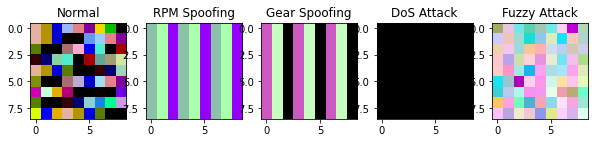

CPU times: user 426 ms, sys: 16.5 ms, total: 442 ms
Wall time: 439 ms


In [18]:
%%time
# Read the images for each category, the file name may vary (27.png, 83.png...)
img1 = Image.open('./train/0/27.png')
img2 = Image.open('./train/1/83.png')
img3 = Image.open('./train/2/27.png')
img4 = Image.open('./train/3/27.png')
img5 = Image.open('./train/4/27.png')

plt.figure(figsize=(10, 10)) 
plt.subplot(1,5,1)
plt.imshow(img1)
plt.title("Normal")
plt.subplot(1,5,2)
plt.imshow(img2)
plt.title("RPM Spoofing")
plt.subplot(1,5,3)
plt.imshow(img3)
plt.title("Gear Spoofing")
plt.subplot(1,5,4)
plt.imshow(img4)
plt.title("DoS Attack")
plt.subplot(1,5,5)
plt.imshow(img5)
plt.title("Fuzzy Attack")
plt.show()  # display it

## Split the training and test set 

In [19]:
%%time
# Create folders to store images
Train_Dir='./train/'
Val_Dir='./test/'
allimgs=[]
for subdir in os.listdir(Train_Dir):
    for filename in os.listdir(os.path.join(Train_Dir,subdir)):
        filepath=os.path.join(Train_Dir,subdir,filename)
        allimgs.append(filepath)
print(len(allimgs)) # Print the total number of images

29228
CPU times: user 50.2 ms, sys: 15 ms, total: 65.2 ms
Wall time: 64.9 ms


In [20]:
%%time
#split a test set from the dataset, train/test size = 80%/20%
Numbers=len(allimgs)//5 	#size of test set (20%)

def mymovefile(srcfile,dstfile):
    if not os.path.isfile(srcfile):
        print ("%s not exist!"%(srcfile))
    else:
        fpath,fname=os.path.split(dstfile)    
        if not os.path.exists(fpath):
            os.makedirs(fpath)               
        shutil.move(srcfile,dstfile)          
        #print ("move %s -> %s"%(srcfile,dstfile))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 5.96 µs


In [21]:

%%time
# The size of test set
Numbers

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.44 µs


5845

In [22]:
%%time
# Create the test set
val_imgs=random.sample(allimgs,Numbers)
for img in val_imgs:
    dest_path=img.replace(Train_Dir,Val_Dir)
    mymovefile(img,dest_path)
print('Finish creating test set')

Finish creating test set
CPU times: user 68.7 ms, sys: 117 ms, total: 186 ms
Wall time: 188 ms


In [23]:
%%time
#resize the images 224*224 for better CNN training
def get_224(folder,dstdir):
    imgfilepaths=[]
    for root,dirs,imgs in os.walk(folder):
        for thisimg in imgs:
            thisimg_path=os.path.join(root,thisimg)
            imgfilepaths.append(thisimg_path)
    for thisimg_path in imgfilepaths:
        dir_name,filename=os.path.split(thisimg_path)
        dir_name=dir_name.replace(folder,dstdir)
        new_file_path=os.path.join(dir_name,filename)
        if not os.path.exists(dir_name):
            os.makedirs(dir_name)
        img=cv2.imread(thisimg_path)
        img=cv2.resize(img,(224,224))
        cv2.imwrite(new_file_path,img)
    print('Finish resizing'.format(folder=folder))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs


In [24]:
%%time
DATA_DIR_224='./train_224/'
get_224(folder='./train/',dstdir=DATA_DIR_224)

Finish resizing
CPU times: user 48.5 s, sys: 3.08 s, total: 51.6 s
Wall time: 52.2 s


In [25]:
%%time
DATA_DIR2_224='./test_224/'
get_224(folder='./test/',dstdir=DATA_DIR2_224)

Finish resizing
CPU times: user 12 s, sys: 741 ms, total: 12.7 s
Wall time: 12.7 s


# CHAPTER 2: A Transfer Learning and Optimized CNN Based Intrusion Detection System for Internet of Vehicles 
This is the code for the paper entitled "**A Transfer Learning and Optimized CNN Based Intrusion Detection System for Internet of Vehicles**" accepted in IEEE International Conference on Communications (IEEE ICC).  
Authors: Li Yang (lyang339@uwo.ca) and Abdallah Shami (Abdallah.Shami@uwo.ca)  
Organization: The Optimized Computing and Communications (OC2) Lab, ECE Department, Western University

**Notebook 2: CNN Model Development**  
Aims:  
&nbsp; 1): Generate training and test images  
&nbsp; 2): Construct CNN models (a CNN model by own, Xception, VGG16, VGG19, Resnet, Inception, InceptionResnet)  
&nbsp; 3): Tune the hyperparameters of CNN models (hyperparameter optimization)  

## Import libraries

In [26]:
import os
from keras.preprocessing.image import  ImageDataGenerator
from keras.layers import Dense,Flatten,GlobalAveragePooling2D,Input,Conv2D,MaxPooling2D,Dropout
from keras.models import Model,load_model,Sequential
from keras.applications.xception import  Xception
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50 #from keras_applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.mobilenet import MobileNet
import keras.callbacks as kcallbacks
import keras
from keras.preprocessing.image import load_img,img_to_array
import math
import random
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import numpy as np
from PIL import Image
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score


import tensorflow as tf 

## Generate Training and Test Images

In [36]:
%%time
#generate training and test images
TARGET_SIZE=(224,224)
INPUT_SIZE=(224,224,3)
BATCHSIZE=128	#could try 128 or 32

#Normalization
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        './train_224/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        './test_224/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')

Found 23383 images belonging to 5 classes.
Found 5845 images belonging to 5 classes.
CPU times: user 1.05 s, sys: 124 ms, total: 1.18 s
Wall time: 1.66 s


### Define the image plotting functions

In [28]:
%%time
#plot the figures
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}
    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))
    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))
    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # acc
            plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
            # loss
            plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

CPU times: user 32 µs, sys: 0 ns, total: 32 µs
Wall time: 34.6 µs


In [29]:
%%time
history_this= LossHistory()

CPU times: user 17 µs, sys: 1 µs, total: 18 µs
Wall time: 21 µs


# Construct CNN models

### Model 1: a CNN model by own (baseline)

In [39]:
%%time
def cnn_by_own(input_shape,num_class,epochs,savepath='./model_own.h5'):
    model = Sequential()
    model.add(Conv2D(64,(3,3),strides=(1,1),input_shape=input_shape,padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(64,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(128,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(128,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(num_class,activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    #train model
    earlyStopping=kcallbacks.EarlyStopping(monitor='val_accuracy', patience=2, verbose=1, mode='auto')
    saveBestModel = kcallbacks.ModelCheckpoint(filepath=savepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
    hist=model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        callbacks=[earlyStopping,saveBestModel,history_this],
        #workers=2, use_multiprocessing=True
    )

CPU times: user 0 ns, sys: 7 µs, total: 7 µs
Wall time: 11.2 µs


Epoch 1/20
183/183 [==============================] - ETA: 0s - loss: 0.1787 - accuracy: 0.9362
Epoch 1: val_accuracy improved from -inf to 0.97930, saving model to ./model_own.h5
183/183 [==============================] - 267s 1s/step - loss: 0.1787 - accuracy: 0.9362 - val_loss: 0.0595 - val_accuracy: 0.9793
Epoch 2/20
183/183 [==============================] - ETA: 0s - loss: 0.0269 - accuracy: 0.9941
Epoch 2: val_accuracy did not improve from 0.97930
183/183 [==============================] - 271s 1s/step - loss: 0.0269 - accuracy: 0.9941 - val_loss: 0.0729 - val_accuracy: 0.9588
Epoch 3/20
183/183 [==============================] - ETA: 0s - loss: 0.0079 - accuracy: 0.9968
Epoch 3: val_accuracy improved from 0.97930 to 1.00000, saving model to ./model_own.h5
183/183 [==============================] - 268s 1s/step - loss: 0.0079 - accuracy: 0.9968 - val_loss: 1.0517e-04 - val_accuracy: 1.0000
Epoch 4/20
183/183 [==============================] - ETA: 0s - loss: 0.0430 - accuracy: 0

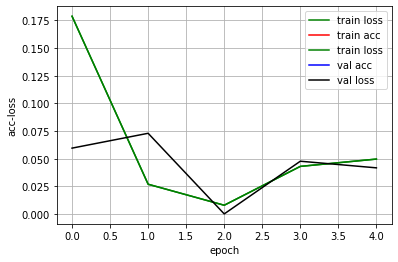

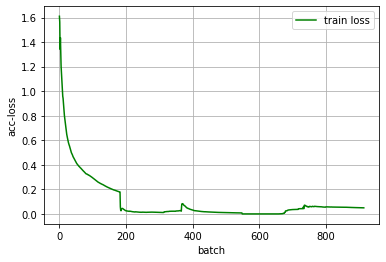

CPU times: user 15min 13s, sys: 1min 23s, total: 16min 36s
Wall time: 23min 29s


In [41]:
%%time
cnn_by_own(input_shape=INPUT_SIZE,num_class=5,epochs=20)
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

Validation accuracy of a CNN by own: 99.884%

### Model 2: Xception

In [42]:
%%time
def xception( num_class, epochs,savepath='./xception.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = Xception(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:131]:		#could be tuned to be 50, 100, or 131
        layer.trainable = False
    for layer in model_fine_tune.layers[131:]:
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='xception')
    opt = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=3, verbose=1, mode='auto')	#patience could be tuned by 2 and 3
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        callbacks=[earlyStopping, saveBestModel, history],
    )


CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 10.7 µs


83697664/83683744 [==============================] - 2s 0us/step
Epoch 1/20
183/183 [==============================] - ETA: 0s - loss: 0.0352 - accuracy: 0.9899
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to ./xception.h5
183/183 [==============================] - 145s 756ms/step - loss: 0.0352 - accuracy: 0.9899 - val_loss: 2.4746e-04 - val_accuracy: 1.0000
Epoch 2/20
183/183 [==============================] - ETA: 0s - loss: 4.1415e-04 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
183/183 [==============================] - 149s 814ms/step - loss: 4.1415e-04 - accuracy: 1.0000 - val_loss: 8.0213e-05 - val_accuracy: 1.0000
Epoch 3/20
183/183 [==============================] - ETA: 0s - loss: 1.9556e-04 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
183/183 [==============================] - 134s 732ms/step - loss: 1.9556e-04 - accuracy: 1.0000 - val_loss: 2.8245e-05 - val_accuracy: 1.0000
Epoch 4/20
183/183 [=========

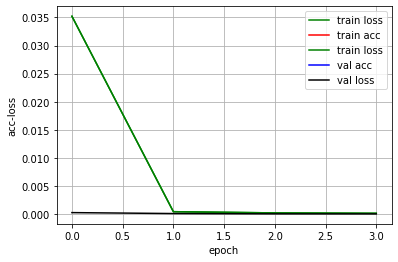

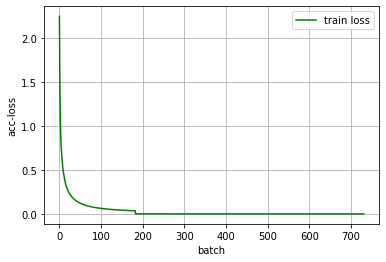

CPU times: user 6min 30s, sys: 32.6 s, total: 7min 2s
Wall time: 9min 43s


In [43]:
%%time
#default only 50, tf36cnn 99
xception(num_class=5,epochs=20)
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

Validation accuracy of Xception: 100.0%

### Model 3: VGG16

In [44]:
def vgg16( num_class, epochs,savepath='./VGG16.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:15]:	#the number of frozen layers for transfer learning, have tuned from 5-18
        layer.trainable = False
    for layer in model_fine_tune.layers[15:]:
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output) #GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='vgg')
    opt = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])	#set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=2, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        #workers=2,
        callbacks=[earlyStopping, saveBestModel, history],
    )


58900480/58889256 [==============================] - 1s 0us/step
Epoch 1/20
183/183 [==============================] - ETA: 0s - loss: 0.0681 - accuracy: 0.9782
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to ./VGG16.h5
183/183 [==============================] - 169s 902ms/step - loss: 0.0681 - accuracy: 0.9782 - val_loss: 1.0670e-07 - val_accuracy: 1.0000
Epoch 2/20
183/183 [==============================] - ETA: 0s - loss: 9.8735e-06 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
183/183 [==============================] - 163s 890ms/step - loss: 9.8735e-06 - accuracy: 1.0000 - val_loss: 1.6316e-10 - val_accuracy: 1.0000
Epoch 3/20
183/183 [==============================] - ETA: 0s - loss: 9.8129e-07 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
183/183 [==============================] - 163s 892ms/step - loss: 9.8129e-07 - accuracy: 1.0000 - val_loss: 6.1185e-11 - val_accuracy: 1.0000
Epoch 3: early stopping


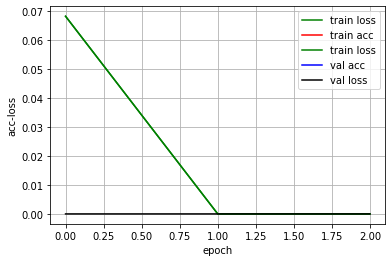

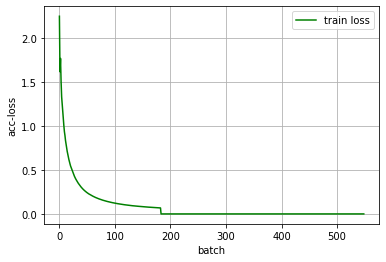

CPU times: user 5min 29s, sys: 24.1 s, total: 5min 53s
Wall time: 8min 17s


In [45]:
%%time
vgg16(num_class=5,epochs=20)	#tf36cnn
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

Validation accuracy of VGG16: 100.0%

### Model 4: VGG19

In [46]:
def vgg19( num_class, epochs,savepath='./VGG19.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:19]:	#the number of frozen layers for transfer learning, have tuned from 5-18
        layer.trainable = False
    for layer in model_fine_tune.layers[19:]:
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='vgg')
    opt = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])	#set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=2, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        #workers=2,
        callbacks=[earlyStopping, saveBestModel, history],
    )


80150528/80134624 [==============================] - 3s 0us/step
Epoch 1/20
183/183 [==============================] - ETA: 0s - loss: 0.0217 - accuracy: 0.9928
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to ./VGG19.h5
183/183 [==============================] - 187s 1s/step - loss: 0.0217 - accuracy: 0.9928 - val_loss: 1.5500e-09 - val_accuracy: 1.0000
Epoch 2/20
183/183 [==============================] - ETA: 0s - loss: 1.7597e-06 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
183/183 [==============================] - 186s 1s/step - loss: 1.7597e-06 - accuracy: 1.0000 - val_loss: 5.3027e-10 - val_accuracy: 1.0000
Epoch 3/20
183/183 [==============================] - ETA: 0s - loss: 3.8210e-07 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
183/183 [==============================] - 186s 1s/step - loss: 3.8210e-07 - accuracy: 1.0000 - val_loss: 3.4672e-10 - val_accuracy: 1.0000
Epoch 3: early stopping


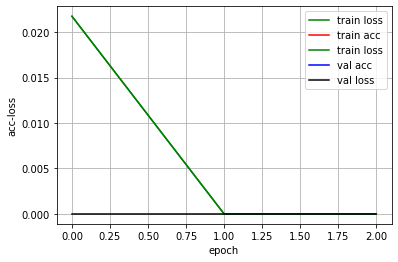

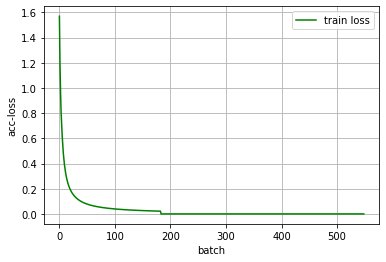

CPU times: user 5min 16s, sys: 25.9 s, total: 5min 42s
Wall time: 9min 24s


In [47]:
%%time
vgg19(num_class=5,epochs=20)	#binary classificaiton
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

Validation accuracy of VGG19: 100.0%

### Model 5: ResNet

In [48]:
def resnet( num_class, epochs,savepath='./resnet.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:120]:	#the number of frozen layers for transfer learning, have tuned from 50-150
        layer.trainable = False
    for layer in model_fine_tune.layers[120:]:	#the number of trainable layers for transfer learning
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='resnet')
    opt = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) #set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=2, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        callbacks=[earlyStopping, saveBestModel, history],
    )

94781440/94765736 [==============================] - 1s 0us/step
Epoch 1/20
183/183 [==============================] - ETA: 0s - loss: 0.1833 - accuracy: 0.9392
Epoch 1: val_accuracy improved from -inf to 0.85937, saving model to ./resnet.h5
183/183 [==============================] - 146s 754ms/step - loss: 0.1833 - accuracy: 0.9392 - val_loss: 260.3405 - val_accuracy: 0.8594
Epoch 2/20
183/183 [==============================] - ETA: 0s - loss: 0.0579 - accuracy: 0.9840
Epoch 2: val_accuracy did not improve from 0.85937
183/183 [==============================] - 133s 726ms/step - loss: 0.0579 - accuracy: 0.9840 - val_loss: 66.7907 - val_accuracy: 0.8594
Epoch 3/20
183/183 [==============================] - ETA: 0s - loss: 0.0089 - accuracy: 0.9979
Epoch 3: val_accuracy did not improve from 0.85937
183/183 [==============================] - 132s 722ms/step - loss: 0.0089 - accuracy: 0.9979 - val_loss: 6.1496 - val_accuracy: 0.8594
Epoch 3: early stopping


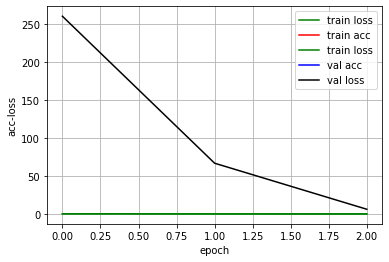

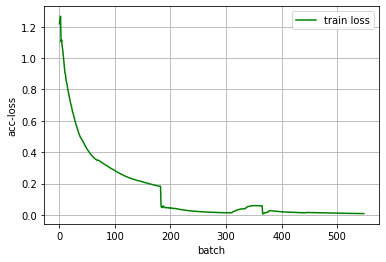

CPU times: user 6min 42s, sys: 21 s, total: 7min 3s
Wall time: 6min 54s


In [49]:
%%time
resnet(num_class=5,epochs=20)	#binary classificaiton
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

Validation accuracy of Resnet: 98.652%

### Model 6: Inception

In [50]:
def inception( num_class, epochs,savepath='./inception.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:35]:	#the number of frozen layers for transfer learning, have tuned from 50-150
        layer.trainable = False
    for layer in model_fine_tune.layers[35:]:	#the number of trainable layers for transfer learning
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='resnet')
    opt = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) #set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=2, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        callbacks=[earlyStopping, saveBestModel, history],
    )

87924736/87910968 [==============================] - 3s 0us/step
Epoch 1/20
183/183 [==============================] - ETA: 0s - loss: 0.0336 - accuracy: 0.9917
Epoch 1: val_accuracy improved from -inf to 0.04123, saving model to ./inception.h5
183/183 [==============================] - 169s 847ms/step - loss: 0.0336 - accuracy: 0.9917 - val_loss: 17113.0488 - val_accuracy: 0.0412
Epoch 2/20
183/183 [==============================] - ETA: 0s - loss: 0.0280 - accuracy: 0.9950
Epoch 2: val_accuracy improved from 0.04123 to 0.88931, saving model to ./inception.h5
183/183 [==============================] - 145s 790ms/step - loss: 0.0280 - accuracy: 0.9950 - val_loss: 199.1083 - val_accuracy: 0.8893
Epoch 3/20
183/183 [==============================] - ETA: 0s - loss: 0.0162 - accuracy: 0.9973
Epoch 3: val_accuracy improved from 0.88931 to 0.96476, saving model to ./inception.h5
183/183 [==============================] - 144s 783ms/step - loss: 0.0162 - accuracy: 0.9973 - val_loss: 4.1870 -

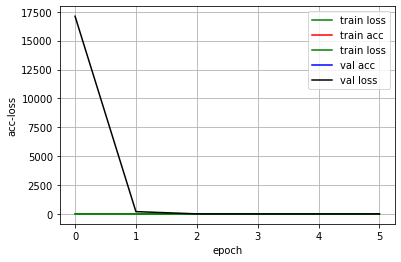

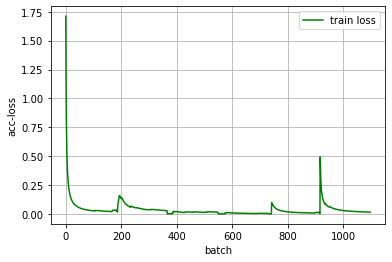

CPU times: user 17min 10s, sys: 31.5 s, total: 17min 41s
Wall time: 14min 51s


In [51]:
%%time
inception(num_class=5,epochs=20)	#binary classificaiton
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

Validation accuracy of Inception: 100.0%

### Model 7: InceptionResnet

In [52]:
%%time
def inceptionresnet( num_class, epochs,savepath='./inceptionresnet.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:500]:	#the number of frozen layers for transfer learning, have tuned from 400-550
        layer.trainable = False
    for layer in model_fine_tune.layers[500:]:	#the number of trainable layers for transfer learning
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='resnet')
    opt = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) #set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=2, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        callbacks=[earlyStopping, saveBestModel, history],
    )

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


219070464/219055592 [==============================] - 2s 0us/step
Epoch 1/20
183/183 [==============================] - ETA: 0s - loss: 0.0440 - accuracy: 0.9881
Epoch 1: val_accuracy improved from -inf to 0.88931, saving model to ./inceptionresnet.h5
183/183 [==============================] - 241s 1s/step - loss: 0.0440 - accuracy: 0.9881 - val_loss: 8.4516 - val_accuracy: 0.8893
Epoch 2/20
183/183 [==============================] - ETA: 0s - loss: 0.0025 - accuracy: 0.9997
Epoch 2: val_accuracy improved from 0.88931 to 1.00000, saving model to ./inceptionresnet.h5
183/183 [==============================] - 218s 1s/step - loss: 0.0025 - accuracy: 0.9997 - val_loss: 6.0891e-06 - val_accuracy: 1.0000
Epoch 3/20
183/183 [==============================] - ETA: 0s - loss: 2.2075e-05 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
183/183 [==============================] - 217s 1s/step - loss: 2.2075e-05 - accuracy: 1.0000 - val_loss: 2.3175e-07 - val_accuracy: 1.0000

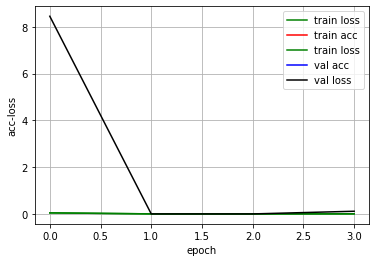

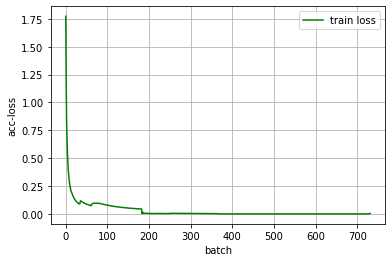

CPU times: user 13min 25s, sys: 1min 19s, total: 14min 44s
Wall time: 15min


In [53]:
%%time
inceptionresnet(num_class=5,epochs=20)	# 5-class classificaiton
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

Validation accuracy of InceptionResnet: 99.993%

# Hyperparameter Optimization 
Use VGG16 as an example.  

Tuned hyperparameters of CNN: 
1. The number of frozen layers
2. The number of epochs
3. Early stop patience
4. Learning rate
5. Dropout rate

Hyperparameter optimization methods:
1. Random search
2. Bayesian optimization - Tree Parzen Estimator(BO-TPE)

In [54]:
def vgg16( num_class,epochs=20,frozen=15,lr=0.001,patience=2, dropout_rate=0.5,verbose=0, savepath='./VGG16.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:frozen]:	#the number of frozen layers for transfer learning, have tuned from 5-18
        layer.trainable = False
    for layer in model_fine_tune.layers[frozen:]:
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(dropout_rate)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='vgg')
    opt = tf.keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])	#set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=patience, verbose=verbose, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=verbose,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        #workers=2,
        callbacks=[earlyStopping, saveBestModel, history],
        verbose = verbose
    )
    return hist


In [55]:
def prediction(vgg_model):
#read images from validation folder
    rootdir = './test_224/'
    test_laels = []
    test_images=[]
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if not (file.endswith(".jpeg"))|(file.endswith(".jpg"))|(file.endswith(".png")):
                continue
            test_laels.append(subdir.split('/')[-1])
            test_images.append(os.path.join(subdir, file))

    predict=[]
    length=len(test_images)
    label=validation_generator.class_indices
    label={v: k for k, v in label.items()}
    for i in range(length):
        inputimg=test_images[i]
        test_batch=[]
        thisimg=np.array(Image.open(inputimg))/255 #read all the images in validation set
        #print(thisimg)
        test_shape=(1,)+thisimg.shape
        thisimg=thisimg.reshape(test_shape)
        vgg_model_batch=vgg_model.predict(thisimg) #use master model to process the input image
        #generate result by model 1
        prob=vgg_model_batch[0,np.argmax(vgg_model_batch,axis=1)[0]]
        res=label[np.argmax(vgg_model_batch,axis=1)[0]]
        predict.append(res)
    acc=accuracy_score(test_laels,predict)
    return acc

In [56]:
%%time
#define the objective function to be optimized
import time
from hyperopt import hp, fmin, tpe, rand, STATUS_OK, Trials
import matplotlib.pyplot as plt
import statistics 

def objective(params):
    
    params = {
        'frozen': int(params['frozen']),
        'epochs': int(params['epochs']),
        'patience': int(params['patience']),
        'lr': abs(float(params['lr'])),
        'dropout_rate': abs(float(params['dropout_rate'])),
    }
    frozen=params['frozen']
    epochs=params['epochs']
    patience=params['patience']
    lr=params['lr']
    dropout_rate=params['dropout_rate']

    vgg16(num_class=5, frozen=frozen,epochs=epochs,patience=patience, lr=lr, dropout_rate=dropout_rate)

    acc=prediction(vgg_model=load_model('./VGG16.h5'))

    print('accuracy:%s'%acc)
    return {'loss': -acc, 'status': STATUS_OK }
    

CPU times: user 138 ms, sys: 27.6 ms, total: 165 ms
Wall time: 399 ms


In [57]:
%%time
#Hyperparameter optimization by Bayesian optimization - Tree Parzen Estimator
'''
space = {
    'frozen': hp.quniform('frozen', 15, 18, 1),
    'epochs': hp.quniform('epochs', 5, 6, 1),
    'patience': hp.quniform('patience', 2, 4, 1),
    'lr': hp.quniform('lr', 0.001, 0.006, 0.001),
    'dropout_rate': hp.quniform('dropout_rate', 0.3, 0.6, 0.1),
}

t1=time.time()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)
print("Hyperopt estimated optimum {}".format(best))
t2=time.time()
print("Time: "+str(t2-t1))
'''

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


'\nspace = {\n    \'frozen\': hp.quniform(\'frozen\', 15, 18, 1),\n    \'epochs\': hp.quniform(\'epochs\', 5, 6, 1),\n    \'patience\': hp.quniform(\'patience\', 2, 4, 1),\n    \'lr\': hp.quniform(\'lr\', 0.001, 0.006, 0.001),\n    \'dropout_rate\': hp.quniform(\'dropout_rate\', 0.3, 0.6, 0.1),\n}\n\nt1=time.time()\nbest = fmin(fn=objective,\n            space=space,\n            algo=tpe.suggest,\n            max_evals=10)\nprint("Hyperopt estimated optimum {}".format(best))\nt2=time.time()\nprint("Time: "+str(t2-t1))\n'

In [58]:
%%time
#Hyperparameter optimization by Random search
'''
space = {
    'frozen': hp.quniform('frozen', 15, 18, 1),
    'epochs': hp.quniform('epochs', 5, 21, 5),
    'patience': hp.quniform('patience', 2, 4, 1),
    'lr': hp.quniform('lr', 0.001, 0.006, 0.001),
    'dropout_rate': hp.quniform('dropout_rate', 0.3, 0.6, 0.1),
}

t1=time.time()
best = fmin(fn=objective,
            space=space,
            algo=rand.suggest,
            max_evals=10)
print("Hyperopt estimated optimum {}".format(best))
t2=time.time()
print("Time: "+str(t2-t1))
'''

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs


'\nspace = {\n    \'frozen\': hp.quniform(\'frozen\', 15, 18, 1),\n    \'epochs\': hp.quniform(\'epochs\', 5, 21, 5),\n    \'patience\': hp.quniform(\'patience\', 2, 4, 1),\n    \'lr\': hp.quniform(\'lr\', 0.001, 0.006, 0.001),\n    \'dropout_rate\': hp.quniform(\'dropout_rate\', 0.3, 0.6, 0.1),\n}\n\nt1=time.time()\nbest = fmin(fn=objective,\n            space=space,\n            algo=rand.suggest,\n            max_evals=10)\nprint("Hyperopt estimated optimum {}".format(best))\nt2=time.time()\nprint("Time: "+str(t2-t1))\n'

In [59]:
%%time
# Retrain the model by using the best hyperparameter values to obtain the best model
#vgg16(num_class=5, frozen=16,epochs=15,patience=3, lr=0.002, dropout_rate=0.6,verbose=1)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs


# CHAPTER 3: A Transfer Learning and Optimized CNN Based Intrusion Detection System for Internet of Vehicles 
This is the code for the paper entitled "**A Transfer Learning and Optimized CNN Based Intrusion Detection System for Internet of Vehicles**" accepted in IEEE International Conference on Communications (IEEE ICC).  
Authors: Li Yang (lyang339@uwo.ca) and Abdallah Shami (Abdallah.Shami@uwo.ca)  
Organization: The Optimized Computing and Communications (OC2) Lab, ECE Department, Western University

**Notebook 3: Ensemble Models**  
Aims:  construct three ensemble techniques: Bagging, Probability averaging, and Concatenation, to further improve prediction accuracy  
* Bagging: use majority voting of top single models  
* Probability averaging: calculate the average probability of the single model prediction results (the last layer of CNN models), and select the largest probability class to be the final class  
* Concatenation: extract the features in the last several layers of single models, and concatenate together to generate the new layers, and add a dense layer to do prediction

## Import libraries

In [60]:
import warnings
warnings.filterwarnings("ignore")
import keras
from keras.models import Model,load_model
from keras import Input
from keras.layers import concatenate,Dense,Flatten,Dropout
from keras.preprocessing.image import  ImageDataGenerator
import keras.callbacks as kcallbacks
import os
import math
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from keras.optimizers import gradient_descent_v2 #from keras.optimizers import SGD
import operator
import numpy as np
from PIL import Image
from collections import defaultdict

## Read the test set

In [61]:
%%time
#generate images from train set and validation set
TARGET_SIZE=(224,224)
INPUT_SIZE=(224,224,3)
BATCHSIZE=128

test_datagen = ImageDataGenerator(rescale=1./255)


validation_generator = test_datagen.flow_from_directory(
        './test_224/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')

Found 5845 images belonging to 5 classes.
CPU times: user 214 ms, sys: 84.2 ms, total: 298 ms
Wall time: 242 ms


In [62]:
%%time
#generate labels indicating disease (1) or normal (0)
label=validation_generator.class_indices
label={v: k for k, v in label.items()}

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 8.82 µs


In [63]:
print(label)

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4'}


In [64]:
%%time
#read images from validation folder
rootdir = './test_224/'
test_laels = []
test_images=[]
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if not (file.endswith(".jpeg"))|(file.endswith(".jpg"))|(file.endswith(".png")):
            continue
        test_laels.append(subdir.split('/')[-1])
        test_images.append(os.path.join(subdir, file))
        
print(test_laels[0],test_images[0])

3 ./test_224/3/10415.png
CPU times: user 17.7 ms, sys: 1.87 ms, total: 19.6 ms
Wall time: 20 ms


## Load 5 trained CNN models

In [65]:
%%time
 #load model 1: xception
xception_model=load_model('./xception.h5')

CPU times: user 1.17 s, sys: 186 ms, total: 1.36 s
Wall time: 1.56 s


In [66]:
%%time
 #load model 2: VGG16
vgg_model=load_model('./VGG16.h5')

CPU times: user 385 ms, sys: 136 ms, total: 521 ms
Wall time: 694 ms


In [67]:
%%time
 #load model 3: VGG19
vgg19_model=load_model('./VGG19.h5')

CPU times: user 408 ms, sys: 107 ms, total: 515 ms
Wall time: 690 ms


In [68]:
%%time
 #load model 4: inception
incep_model=load_model('./inception.h5')

CPU times: user 3.29 s, sys: 368 ms, total: 3.66 s
Wall time: 4.11 s


In [69]:
%%time
 #load model 5: inceptionresnet
inres_model=load_model('./inceptionresnet.h5')

CPU times: user 6.6 s, sys: 855 ms, total: 7.45 s
Wall time: 8.35 s


## Use the original CNN base models to make predictions

### 1. Xception

Predicted result for the first image: 3
Confidence level: 0.9958246


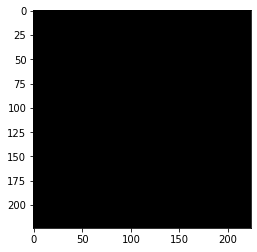

CPU times: user 178 ms, sys: 4.74 ms, total: 183 ms
Wall time: 187 ms


In [72]:
%%time
#Single image prediction
import cv2
import matplotlib.pyplot as plt
test=cv2.imread(test_images[0])

img_show=test[:,:,[2,1,0]]
test=test/255.
test_shape=(1,)+test.shape
test=test.reshape(test_shape)

res=xception_model.predict(test)

prob=res[0,np.argmax(res,axis=1)[0]]
res=label[np.argmax(res,axis=1)[0]]
print('Predicted result for the first image: %s'%res)
print('Confidence level: %s'%prob)
plt.imshow(img_show)
plt.show()

In [73]:
%%time
import time
predict=[]
length=len(test_images)
t1 = time.time()
for i in range(length):
    inputimg=test_images[i]
    test_batch=[]
    thisimg=np.array(Image.open(inputimg))/255 #read all the images in validation set
    #print(thisimg)
    test_shape=(1,)+thisimg.shape
    thisimg=thisimg.reshape(test_shape)
    xception_model_batch=xception_model.predict(thisimg) #use master model to process the input image
    #generate result by model 1
    prob=xception_model_batch[0,np.argmax(xception_model_batch,axis=1)[0]]
    res=label[np.argmax(xception_model_batch,axis=1)[0]]
    predict.append(res)
    

CPU times: user 5min 44s, sys: 10.8 s, total: 5min 55s
Wall time: 6min 11s


In [74]:
%%time
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
acc=accuracy_score(test_laels,predict)
pre=precision_score(test_laels,predict,average='weighted')
re=recall_score(test_laels,predict,average='weighted')
f1=f1_score(test_laels,predict,average='weighted')
print('Xception accuracy: %s'%acc)
print('precision: %s'%pre)
print('recall: %s'%re)
print('f1: %s'%f1)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(test_laels, predict))
target_names = ['0', '1','2','3','4']
print(classification_report(test_laels, predict, target_names=target_names))

Xception accuracy: 1.0
precision: 1.0
recall: 1.0
f1: 1.0
[[5023    0    0    0    0]
 [   0  241    0    0    0]
 [   0    0  194    0    0]
 [   0    0    0  211    0]
 [   0    0    0    0  176]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5023
           1       1.00      1.00      1.00       241
           2       1.00      1.00      1.00       194
           3       1.00      1.00      1.00       211
           4       1.00      1.00      1.00       176

    accuracy                           1.00      5845
   macro avg       1.00      1.00      1.00      5845
weighted avg       1.00      1.00      1.00      5845

CPU times: user 105 ms, sys: 5.2 ms, total: 110 ms
Wall time: 120 ms


### 2. VGG16

In [75]:
%%time
predict=[]
length=len(test_images)
t1 = time.time()
for i in range(length):
    inputimg=test_images[i]
    test_batch=[]
    thisimg=np.array(Image.open(inputimg))/255 #read all the images in validation set
    #print(thisimg)
    test_shape=(1,)+thisimg.shape
    thisimg=thisimg.reshape(test_shape)
    vgg_model_batch=vgg_model.predict(thisimg) #use master model to process the input image
    #generate result by model 1
    prob=vgg_model_batch[0,np.argmax(vgg_model_batch,axis=1)[0]]
    res=label[np.argmax(vgg_model_batch,axis=1)[0]]
    predict.append(res)
    

CPU times: user 5min 34s, sys: 10.8 s, total: 5min 45s
Wall time: 5min 50s


In [76]:
%%time
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
acc=accuracy_score(test_laels,predict)
pre=precision_score(test_laels,predict,average='weighted')
re=recall_score(test_laels,predict,average='weighted')
f1=f1_score(test_laels,predict,average='weighted')
print('VGG16 accuracy: %s'%acc)
print('precision: %s'%pre)
print('recall: %s'%re)
print('f1: %s'%f1)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(test_laels, predict))
target_names = ['0', '1','2','3','4']
print(classification_report(test_laels, predict, target_names=target_names))

VGG16 accuracy: 1.0
precision: 1.0
recall: 1.0
f1: 1.0
[[5023    0    0    0    0]
 [   0  241    0    0    0]
 [   0    0  194    0    0]
 [   0    0    0  211    0]
 [   0    0    0    0  176]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5023
           1       1.00      1.00      1.00       241
           2       1.00      1.00      1.00       194
           3       1.00      1.00      1.00       211
           4       1.00      1.00      1.00       176

    accuracy                           1.00      5845
   macro avg       1.00      1.00      1.00      5845
weighted avg       1.00      1.00      1.00      5845

CPU times: user 106 ms, sys: 1.88 ms, total: 108 ms
Wall time: 106 ms


### 3. VGG19

In [77]:
%%time
predict=[]
length=len(test_images)
t1 = time.time()
for i in range(length):
    inputimg=test_images[i]
    test_batch=[]
    thisimg=np.array(Image.open(inputimg))/255 #read all the images in validation set
    #print(thisimg)
    test_shape=(1,)+thisimg.shape
    thisimg=thisimg.reshape(test_shape)
    vgg19_model_batch=vgg19_model.predict(thisimg) #use master model to process the input image
    #generate result by model 1
    prob=vgg19_model_batch[0,np.argmax(vgg19_model_batch,axis=1)[0]]
    res=label[np.argmax(vgg19_model_batch,axis=1)[0]]
    predict.append(res)
    

CPU times: user 5min 52s, sys: 10.7 s, total: 6min 3s
Wall time: 5min 59s


In [78]:
%%time
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
acc=accuracy_score(test_laels,predict)
pre=precision_score(test_laels,predict,average='weighted')
re=recall_score(test_laels,predict,average='weighted')
f1=f1_score(test_laels,predict,average='weighted')
print('VGG19 accuracy: %s'%acc)
print('precision: %s'%pre)
print('recall: %s'%re)
print('f1: %s'%f1)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(test_laels, predict))
target_names = ['0', '1','2','3','4']
print(classification_report(test_laels, predict, target_names=target_names))

VGG19 accuracy: 1.0
precision: 1.0
recall: 1.0
f1: 1.0
[[5023    0    0    0    0]
 [   0  241    0    0    0]
 [   0    0  194    0    0]
 [   0    0    0  211    0]
 [   0    0    0    0  176]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5023
           1       1.00      1.00      1.00       241
           2       1.00      1.00      1.00       194
           3       1.00      1.00      1.00       211
           4       1.00      1.00      1.00       176

    accuracy                           1.00      5845
   macro avg       1.00      1.00      1.00      5845
weighted avg       1.00      1.00      1.00      5845

CPU times: user 109 ms, sys: 1.95 ms, total: 111 ms
Wall time: 109 ms


### 4. Inception

In [79]:
%%time
predict=[]
length=len(test_images)
t1 = time.time()
for i in range(length):
    inputimg=test_images[i]
    test_batch=[]
    thisimg=np.array(Image.open(inputimg))/255 #read all the images in validation set
    #print(thisimg)
    test_shape=(1,)+thisimg.shape
    thisimg=thisimg.reshape(test_shape)
    incep_model_batch=incep_model.predict(thisimg) #use master model to process the input image
    #generate result by model 1
    prob=incep_model_batch[0,np.argmax(incep_model_batch,axis=1)[0]]
    res=label[np.argmax(incep_model_batch,axis=1)[0]]
    predict.append(res)
    

CPU times: user 6min 23s, sys: 10.5 s, total: 6min 34s
Wall time: 6min 33s


In [80]:
%%time
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
acc=accuracy_score(test_laels,predict)
pre=precision_score(test_laels,predict,average='weighted')
re=recall_score(test_laels,predict,average='weighted')
f1=f1_score(test_laels,predict,average='weighted')
print('inception accuracy: %s'%acc)
print('precision: %s'%pre)
print('recall: %s'%re)
print('f1: %s'%f1)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(test_laels, predict))
target_names = ['0', '1','2','3','4']
print(classification_report(test_laels, predict, target_names=target_names))

inception accuracy: 1.0
precision: 1.0
recall: 1.0
f1: 1.0
[[5023    0    0    0    0]
 [   0  241    0    0    0]
 [   0    0  194    0    0]
 [   0    0    0  211    0]
 [   0    0    0    0  176]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5023
           1       1.00      1.00      1.00       241
           2       1.00      1.00      1.00       194
           3       1.00      1.00      1.00       211
           4       1.00      1.00      1.00       176

    accuracy                           1.00      5845
   macro avg       1.00      1.00      1.00      5845
weighted avg       1.00      1.00      1.00      5845

CPU times: user 99.2 ms, sys: 812 µs, total: 100 ms
Wall time: 101 ms


### 5. InceptionResnet

In [81]:
%%time
predict=[]
length=len(test_images)
t1 = time.time()
for i in range(length):
    inputimg=test_images[i]
    test_batch=[]
    thisimg=np.array(Image.open(inputimg))/255 #read all the images in validation set
    #print(thisimg)
    test_shape=(1,)+thisimg.shape
    thisimg=thisimg.reshape(test_shape)
    inres_model_batch=inres_model.predict(thisimg) #use master model to process the input image
    #generate result by model 1
    prob=inres_model_batch[0,np.argmax(inres_model_batch,axis=1)[0]]
    res=label[np.argmax(inres_model_batch,axis=1)[0]]
    predict.append(res)
    

CPU times: user 8min 26s, sys: 11.2 s, total: 8min 37s
Wall time: 8min 37s


In [82]:
%%time
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
acc=accuracy_score(test_laels,predict)
pre=precision_score(test_laels,predict,average='weighted')
re=recall_score(test_laels,predict,average='weighted')
f1=f1_score(test_laels,predict,average='weighted')
print('inceptionresnet accuracy: %s'%acc)
print('precision: %s'%pre)
print('recall: %s'%re)
print('f1: %s'%f1)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(test_laels, predict))
target_names = ['0', '1','2','3','4']
print(classification_report(test_laels, predict, target_names=target_names))

inceptionresnet accuracy: 1.0
precision: 1.0
recall: 1.0
f1: 1.0
[[5023    0    0    0    0]
 [   0  241    0    0    0]
 [   0    0  194    0    0]
 [   0    0    0  211    0]
 [   0    0    0    0  176]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5023
           1       1.00      1.00      1.00       241
           2       1.00      1.00      1.00       194
           3       1.00      1.00      1.00       211
           4       1.00      1.00      1.00       176

    accuracy                           1.00      5845
   macro avg       1.00      1.00      1.00      5845
weighted avg       1.00      1.00      1.00      5845

CPU times: user 98.4 ms, sys: 3.97 ms, total: 102 ms
Wall time: 99.8 ms


### 6. Resnet

In [83]:
 #load model 6: resnet
res_model=load_model('./resnet.h5')

In [84]:
%%time
predict=[]
length=len(test_images)
t1 = time.time()
for i in range(length):
    inputimg=test_images[i]
    test_batch=[]
    thisimg=np.array(Image.open(inputimg))/255 #read all the images in validation set
    #print(thisimg)
    test_shape=(1,)+thisimg.shape
    thisimg=thisimg.reshape(test_shape)
    res_model_batch=res_model.predict(thisimg) #use master model to process the input image
    #generate result by model 1
    prob=res_model_batch[0,np.argmax(res_model_batch,axis=1)[0]]
    res=label[np.argmax(res_model_batch,axis=1)[0]]
    predict.append(res)
    

CPU times: user 5min 45s, sys: 11.2 s, total: 5min 56s
Wall time: 6min 7s


In [85]:
%%time
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
acc=accuracy_score(test_laels,predict)
pre=precision_score(test_laels,predict,average='weighted')
re=recall_score(test_laels,predict,average='weighted')
f1=f1_score(test_laels,predict,average='weighted')
print('resnet accuracy: %s'%acc)
print('precision: %s'%pre)
print('recall: %s'%re)
print('f1: %s'%f1)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(test_laels, predict))
target_names = ['0', '1','2','3','4']
print(classification_report(test_laels, predict, target_names=target_names))

resnet accuracy: 0.8593669803250642
precision: 0.7385116068730192
recall: 0.8593669803250642
f1: 0.7943688520744934
[[5023    0    0    0    0]
 [ 241    0    0    0    0]
 [ 194    0    0    0    0]
 [ 211    0    0    0    0]
 [ 176    0    0    0    0]]
              precision    recall  f1-score   support

           0       0.86      1.00      0.92      5023
           1       0.00      0.00      0.00       241
           2       0.00      0.00      0.00       194
           3       0.00      0.00      0.00       211
           4       0.00      0.00      0.00       176

    accuracy                           0.86      5845
   macro avg       0.17      0.20      0.18      5845
weighted avg       0.74      0.86      0.79      5845

CPU times: user 107 ms, sys: 1.99 ms, total: 109 ms
Wall time: 105 ms


Best performing single model (vgg):  
Accuracy: 99.96

# Bagging ensemble

In [86]:
%%time
import time
predict=[]
length=len(test_images)
t1 = time.time()
for i in range((length//127)+1):
    inputimg=test_images[127*i:127*(i+1)]
    test_batch=[]
    for path in inputimg:
        thisimg=np.array(Image.open(path))/255
        test_batch.append(thisimg)
    #generate result by model 1
    xception_model_batch=xception_model.predict(np.array(test_batch))
    xception_model_batch=list(np.argmax(xception_model_batch,axis=1))
    xception_model_batch=[label[con] for con in xception_model_batch]
#     print(xception_model_batch)
    #generate result by model 2
    vgg_model_batch=vgg_model.predict(np.array(test_batch))
    vgg_model_batch=list(np.argmax(vgg_model_batch,axis=1))
    vgg_model_batch=[label[con] for con in vgg_model_batch]
#     print(vgg_model_batch)
    #generate result by model 3
    vgg19_model_batch=vgg19_model.predict(np.array(test_batch))
    vgg19_model_batch=list(np.argmax(vgg19_model_batch,axis=1))
    vgg19_model_batch=[label[con] for con in vgg19_model_batch]
#     print(vgg19_model_batch)
    #generate result by model 4
    incep_model_batch=incep_model.predict(np.array(test_batch))
    incep_model_batch=list(np.argmax(incep_model_batch,axis=1))
    incep_model_batch=[label[con] for con in incep_model_batch]
#     print(incep_model_batch)
    #generate result by model 5
    inres_model_batch=inres_model.predict(np.array(test_batch))
    inres_model_batch=list(np.argmax(inres_model_batch,axis=1))
    inres_model_batch=[label[con] for con in inres_model_batch]
#     print(inres_model_batch)
    #bagging the three results generated by 3 singular models
    predict_batch=[]
    for i,j,k,p,q in zip(xception_model_batch,vgg_model_batch,vgg19_model_batch,incep_model_batch,inres_model_batch):
        count=defaultdict(int)
        count[i]+=1
        count[j]+=1
        count[k]+=1
        count[p]+=1
        count[q]+=1
        #rank the predicted results in descending order
        predict_one=sorted(count.items(), key=operator.itemgetter(1),reverse=True)[0][0]
        predict_batch.append(predict_one)
#     print('predict:',predict_batch)
    predict.append(predict_batch)
t2 = time.time()
print('The testing time is :%f seconds' % (t2-t1))

The testing time is :222.269670 seconds
CPU times: user 3min 7s, sys: 5.83 s, total: 3min 13s
Wall time: 3min 42s


In [87]:
%%time
predict=sum(predict,[])

CPU times: user 636 µs, sys: 0 ns, total: 636 µs
Wall time: 645 µs


In [88]:
%%time
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
acc=accuracy_score(test_laels,predict)
print('bagging accuracy:%s'%acc)

bagging accuracy:1.0
CPU times: user 5.6 ms, sys: 971 µs, total: 6.57 ms
Wall time: 8.53 ms


In [89]:
%%time
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(test_laels, predict))
target_names = ['0', '1','2','3','4']
print(classification_report(test_laels, predict, target_names=target_names))

[[5023    0    0    0    0]
 [   0  241    0    0    0]
 [   0    0  194    0    0]
 [   0    0    0  211    0]
 [   0    0    0    0  176]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5023
           1       1.00      1.00      1.00       241
           2       1.00      1.00      1.00       194
           3       1.00      1.00      1.00       211
           4       1.00      1.00      1.00       176

    accuracy                           1.00      5845
   macro avg       1.00      1.00      1.00      5845
weighted avg       1.00      1.00      1.00      5845

CPU times: user 47.5 ms, sys: 5 µs, total: 47.5 ms
Wall time: 49 ms


After bagging ensemble, the accuracy improved to 0.990

# Probability Averaging

In [5]:
import tensorflow as tf
import keras
from keras.models import Model,load_model
from keras import Input
from keras.layers import concatenate,Dense,Flatten,Dropout,Average
from keras.preprocessing.image import  ImageDataGenerator
import keras.callbacks as kcallbacks
import os
import math
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from keras.optimizers import gradient_descent_v2 #from keras.optimizers import SGD
import operator
import numpy as np
from PIL import Image
from collections import defaultdict
import tensorflow as tf
#tf.compat.v1.logging.set_verbosity(tf.logging.ERROR)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
%%time
import time
t1 = time.time()
img=Input(shape=(224,224,3),name='img')
feature1=xception_model(img)
feature2=vgg_model(img)
feature3=incep_model(img)
for layer in xception_model.layers:  
    layer.trainable = False 
for layer in vgg_model.layers:  
    layer.trainable = False  
for layer in incep_model.layers:  
    layer.trainable = False  
output=Average()([feature1,feature2,feature3]) #add the confidence lists generated by 3 models
model=Model(inputs=img,outputs=output)

#the optimization function
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
t2 = time.time()
print('The testing time is :%f seconds' % (t2-t1))

In [ ]:
%%time
#read images from validation folder
rootdir = './test_224/'
test_laels = []
test_images=[]
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if not (file.endswith(".jpeg"))|(file.endswith(".jpg"))|(file.endswith(".png")):
            continue
        test_laels.append(subdir.split('/')[-1])
        test_images.append(os.path.join(subdir, file))
        
print(test_laels[0],test_images[0])

In [ ]:
%%time
#test the averaging model on the validation set
import time
predict=[]
length=len(test_images)
t1 = time.time()
for i in range((length//127)+1):
    inputimg=test_images[127*i:127*(i+1)]
    test_batch=[]
    for path in inputimg:
        thisimg=np.array(Image.open(path))/255
        test_batch.append(thisimg)
    #print(i, np.array(test_batch).shape)
    model_batch=model.predict(np.array(test_batch))
    predict_batch=list(np.argmax(model_batch,axis=1))
    predict_batch=[label[con] for con in predict_batch]
    predict.append(predict_batch)

predict=sum(predict,[])

t2 = time.time()
print('The testing time is :%f seconds' % (t2-t1))

In [ ]:
%%time
from sklearn.metrics import accuracy_score
acc=accuracy_score(test_laels,predict)
print('Probability Averaging accuracy:%s'%acc)

In [ ]:
%%time
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(test_laels, predict))
target_names = ['0', '1','2','3','4']
print(classification_report(test_laels, predict, target_names=target_names))

# Concatenation

In [ ]:
import keras
from keras.models import Model,load_model
from keras import Input
from keras.layers import concatenate,Dense,Flatten,Dropout
from keras.preprocessing.image import  ImageDataGenerator
import keras.callbacks as kcallbacks
import os
import math
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from keras.optimizers import gradient_descent_v2 #from keras.optimizers import SGD

In [ ]:
%%time
for i,layer in enumerate(xception_model.layers):
    print(i,layer.name)

In [ ]:
%%time
for i,layer in enumerate(vgg_model.layers):
    print(i,layer.name)

In [ ]:
%%time
for i,layer in enumerate(vgg19_model.layers):
    print(i,layer.name)

In [ ]:
%%time
for i,layer in enumerate(incep_model.layers):
    print(i,layer.name)

In [ ]:
%%time
for i,layer in enumerate(inres_model.layers):
    print(i,layer.name)

### Construct the ensemble model using the last "dense layer" of each base CNN model

In [ ]:
%%time
model1=Model(inputs=[xception_model.layers[0].get_input_at(0)],outputs=xception_model.get_layer('dense_6').output,name='xception')
model2=Model(inputs=[vgg_model.layers[0].get_input_at(0)],outputs=vgg_model.get_layer('dense_8').output,name='vgg')
model3=Model(inputs=[vgg19_model.layers[0].get_input_at(0)],outputs=vgg19_model.get_layer('dense_10').output,name='vgg19')
model4=Model(inputs=[incep_model.layers[0].get_input_at(0)],outputs=incep_model.get_layer('dense_14').output,name='incep')
model5=Model(inputs=[inres_model.layers[0].get_input_at(0)],outputs=inres_model.get_layer('dense_16').output,name='inres')

In [ ]:
#plot the figures
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_accuracy = {'batch':[], 'epoch':[]}
    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_accuracy['batch'].append(logs.get('val_accuracy'))
    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_accuracy['epoch'].append(logs.get('val_accuracy'))
    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # acc
            plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
            # loss
            plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

In [ ]:
%%time
ensemble_history= LossHistory()

In [ ]:
%%time
#generate training and test images
TARGET_SIZE=(224,224)
INPUT_SIZE=(224,224,3)
BATCHSIZE=128	#could try 128 or 32

#Normalization
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        './train_224/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        './test_224/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')

In [ ]:
def lr_decay(epoch):
    lrs = [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0001,0.00001,0.000001,
           0.000001,0.000001,0.000001,0.000001,0.0000001,0.0000001,0.0000001,0.0000001,0.0000001,0.0000001
          ]
    return lrs[epoch]

In [ ]:
%%time
auto_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
my_lr = LearningRateScheduler(lr_decay)

In [ ]:
%%time
def ensemble(num_class,epochs,savepath='./ensemble.h5'):
    img=Input(shape=(224,224,3),name='img')
    feature1=model1(img)
    feature2=model2(img)
    feature3=model3(img)
    x=concatenate([feature1,feature2,feature3])
    x=Dropout(0.5)(x)
    x=Dense(64,activation='relu')(x)
    x=Dropout(0.25)(x)
    output=Dense(num_class,activation='softmax',name='output')(x)
    model=Model(inputs=img,outputs=output)
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    #train model
    earlyStopping=kcallbacks.EarlyStopping(monitor='val_accuracy',patience=2, verbose=1, mode='auto')
    saveBestModel = kcallbacks.ModelCheckpoint(filepath=savepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
    hist=model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        callbacks=[earlyStopping,saveBestModel,ensemble_history,auto_lr],
    )

In [ ]:
%%time
ensemble_model=ensemble(num_class=5,epochs=20)

In [ ]:
%%time
ensemble_model=load_model('./ensemble.h5')

In [ ]:
%%time
#read images from validation folder
rootdir = './test_224/'
test_laels = []
test_images=[]
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if not (file.endswith(".jpeg"))|(file.endswith(".jpg"))|(file.endswith(".png")):
            continue
        test_laels.append(subdir.split('/')[-1])
        test_images.append(os.path.join(subdir, file))
        
print(test_laels[0],test_images[0])

In [ ]:
%%time
#test the averaging model on the validation set
import time
predict=[]
length=len(test_images)
t1 = time.time()
for i in range((length//127)+1):
    inputimg=test_images[127*i:127*(i+1)]
    test_batch=[]
    for path in inputimg:
        thisimg=np.array(Image.open(path))/255
        test_batch.append(thisimg)
    #print(i, np.array(test_batch).shape)
    ensemble_model_batch=ensemble_model.predict(np.array(test_batch))
    predict_batch=list(np.argmax(ensemble_model_batch,axis=1))
    predict_batch=[label[con] for con in predict_batch]
    predict.append(predict_batch)

predict=sum(predict,[])

t2 = time.time()
print('The testing time is :%f seconds' % (t2-t1))

In [ ]:
%%time
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
acc=accuracy_score(test_laels,predict)
print('Concatenation accuracy:%s'%acc)

In [ ]:
%%time
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(test_laels, predict))
target_names = ['0', '1','2','3','4']
print(classification_report(test_laels, predict, target_names=target_names))